**Hesam Ramezanian**

ID : 810100248

AI-CA5

In [1]:
import os
import numpy as np
from torch.utils.data import Dataset ,  random_split , DataLoader , ConcatDataset
from torchvision import transforms
import random
import shutil
from PIL import Image
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import copy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
SIZE = (512,512)
LABELS = ["glioma","meningioma","notumor","pituitary"]

In [3]:

import cv2
os.makedirs('/kaggle/working/train', exist_ok=True)
os.makedirs('/kaggle/working/test', exist_ok=True)
for label in LABELS:
    labelDir = os.path.join('/kaggle/input/dataset/AI-CA5-Dataset/', label)
    images = os.listdir(labelDir)
    random.shuffle(images)
    numOfTrain = int(0.8*len(images))
    trainImages = images[:numOfTrain]
    testImages = images[numOfTrain:]
    os.makedirs('/kaggle/working/test/' + label, exist_ok=True)
    os.makedirs('/kaggle/working/train/' + label, exist_ok=True)
    for image in trainImages:
        src = os.path.join(labelDir,image)
        dst = os.path.join('/kaggle/working/train/', label, image)
        shutil.copyfile(src, dst)
        image = cv2.imread(dst)
        resized = cv2.resize(image, SIZE)
        cv2.imwrite(dst, resized)
    for image in testImages:
        src = os.path.join(labelDir, image)
        dst = os.path.join('/kaggle/working/test/', label, image)
        shutil.copyfile(src, dst)
        image = cv2.imread(dst)
        resized = cv2.resize(image, SIZE)
        cv2.imwrite(dst, resized)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, folderPath, transform=None):
        self.filePaths = []
        for label in LABELS:
          dir = f"{folderPath}/{label}"
          for file in os.listdir(dir):
            if file.endswith(".jpg"):
              self.filePaths.append((LABELS.index(label),os.path.join(dir + "/",file)))
        self.transform = transform

    def __len__(self):
      return len(self.filePaths)

    def __getitem__(self, idx):
        imagePath = self.filePaths[idx][1]
        image = Image.open(imagePath)
        if image.mode != 'L':
          image = image.convert('L')
        if self.transform != None :
            image = self.transform(image)
        return image , self.filePaths[idx][0]

In [5]:
transformsData = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomRotation(10)
])

trainDataset = ImageDataset("/kaggle/working/train" , transform=transformsData )
testDataset = ImageDataset("/kaggle/working/test" , transform=transformsData )
trainLoader = DataLoader(trainDataset, batch_size=32 , shuffle=True)
testLoader = DataLoader(testDataset, batch_size=32 , shuffle=False )

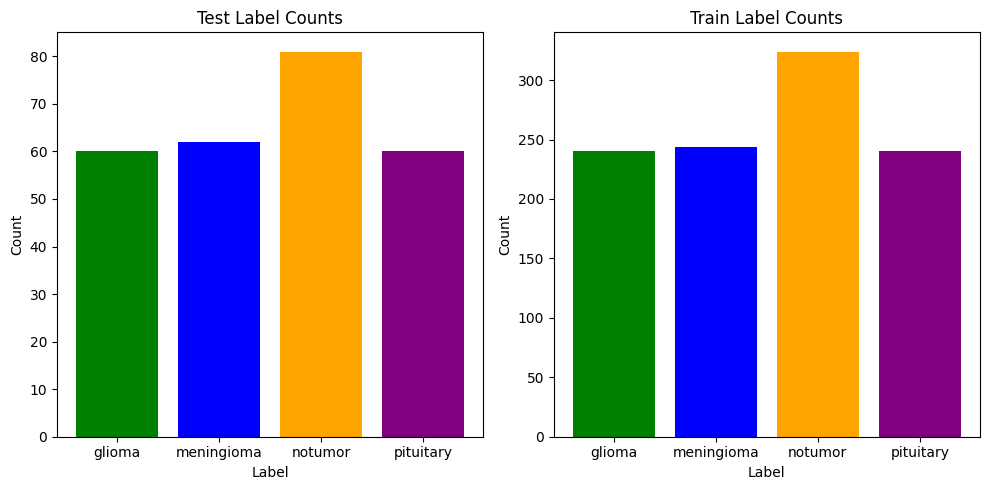


 Train Dataset


,Category,Count
0,glioma,240
1,meningioma,244
2,notumor,324
3,pituitary,240



 Test Dataset


,Category,Count
0,glioma,60
1,meningioma,62
2,notumor,81
3,pituitary,60


In [6]:
import matplotlib.pyplot as plt
from collections import Counter

colors = ['green', 'blue', 'orange', 'purple']

labels = [x[0] for x in testDataset.filePaths]
counts = Counter(labels)
labels, counts = zip(*counts.items())

labels = [LABELS[label] for label in labels]


labels2 = [x[0] for x in trainDataset.filePaths]
counts2 = Counter(labels2)
labels2, counts2 = zip(*counts2.items())

labels2 = [LABELS[label] for label in labels2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(labels, counts, color=colors)
ax1.set_title("Test Label Counts")
ax1.set_xlabel("Label")
ax1.set_ylabel("Count")

ax2.bar(labels2, counts2, color=colors)
ax2.set_title("Train Label Counts")
ax2.set_xlabel("Label")
ax2.set_ylabel("Count")

fig.tight_layout()
plt.show()


testDataFrame = pd.DataFrame({'Category': labels,
                   'Count': counts})
trainDataFrame = pd.DataFrame({'Category': labels2,
                   'Count': counts2})
print("\n Train Dataset")
display(trainDataFrame)
print("\n Test Dataset")
display(testDataFrame)

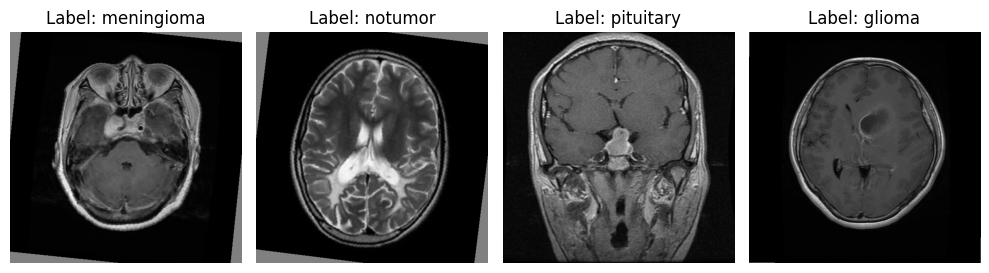

In [7]:

fullDataSet = ConcatDataset([trainDataset, testDataset])
mean = [0.5] 
std = [0.5]
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
imageNumber = 0;
sampelsLabel = []
while(len(sampelsLabel) != 4):
  sample = copy.deepcopy(random.choice(fullDataSet))
  imageTensor, label = sample
  if label in sampelsLabel:
    continue
  sampelsLabel.append(label)
  gray = imageTensor[0]  
  gray = (gray * std[0]) + mean[0]

  denormTensor = gray
  axs[imageNumber].set_title(f"Label: {LABELS[label]}")
  axs[imageNumber].imshow(denormTensor, cmap='gray')
  axs[imageNumber].axis('off')
  imageNumber += 1
plt.tight_layout()
plt.show()

In [49]:
import torch.nn as NeuralNetwork
import torch.optim as optimize
class MyNeuralNetwork(NeuralNetwork.Module):
    def __init__(self, num_classes):
        super(MyNeuralNetwork, self).__init__()
        self.features1 = NeuralNetwork.Sequential(
            NeuralNetwork.Conv2d(1, 16, kernel_size=5, padding=1),
            #NeuralNetwork.BatchNorm2d(16),
            NeuralNetwork.ReLU(inplace=True),
            NeuralNetwork.AvgPool2d(kernel_size=6)
        )
        self.features2 = NeuralNetwork.Sequential(
            NeuralNetwork.Conv2d(16, 32, kernel_size=5, padding=1),
            #NeuralNetwork.BatchNorm2d(32),
            NeuralNetwork.ReLU(inplace=True),
            NeuralNetwork.MaxPool2d(kernel_size=3),
        )
        self.features3 = NeuralNetwork.Sequential(
            NeuralNetwork.Conv2d(32, 64, kernel_size=3, padding=1),
            #NeuralNetwork.BatchNorm2d(64),
            NeuralNetwork.ReLU(inplace=True),
            NeuralNetwork.Conv2d(64, 32, kernel_size=3, padding=1),
            #NeuralNetwork.BatchNorm2d(32),
            NeuralNetwork.ReLU(inplace=True),
            NeuralNetwork.MaxPool2d(kernel_size=2)
        )
        self.classifier = NeuralNetwork.Sequential(
            NeuralNetwork.Dropout(p=0.2),
            NeuralNetwork.Linear(5408, 1352),
            NeuralNetwork.ReLU(inplace=True),
            NeuralNetwork.Dropout(p=0.2),
            NeuralNetwork.Linear(1352, 1352),
            NeuralNetwork.ReLU(inplace=True),
            NeuralNetwork.Linear(1352, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = NeuralNetwork.Flatten()(x)
        x = self.classifier(x)
        return x




device = torch.device('cuda')
model = MyNeuralNetwork(num_classes=4).to(device = device)
optimizer = optimize.Adam(model.parameters(), lr=0.001)
criterion = NeuralNetwork.CrossEntropyLoss()

from tqdm import tqdm
trainLosses = []
testLosses = []
trainAccuracies = []
testAccuracies = []
print(device)
numOfEpochs = 50
bestAccuracy = 0.0
bestConfusionMatrix = torch.zeros(4, 4)

for epoch in range(numOfEpochs):
    model.train()
    trainLoss = 0.0
    correct = 0
    total = 0
    confusionMatrix = torch.zeros(4, 4)
    loop = tqdm(enumerate(trainLoader) , total = len(trainLoader))

    for _, (inputs, labels) in loop :
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        trainLoss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    trainAccuracy = correct / total
    trainLosses.append(trainLoss)
    trainAccuracies.append(trainAccuracy)
    correct = 0
    total = 0
    testLoss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss += loss.item()
            _,predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            for t, p in zip(labels, predicted):
              confusionMatrix[t][p] += 1
    testLoss /= len(testLoader)
    testAccuracy = correct / total
    testLosses.append(testLoss)
    testAccuracies.append(testAccuracy)
    print(f'Epoch <{epoch+1}/{numOfEpochs}>,'
          f'Training Loss: {trainLoss:.2f} , Test Loss: {testLoss:.2f} |'
          f'Training Accuracy: {trainAccuracy:.2%}, Test Accuracy: {testAccuracy:.2%}')
    if testAccuracy > bestAccuracy:
        bestAccuracy = testAccuracy
        bestConfusionMatrix = copy.deepcopy(confusionMatrix)

cuda


100%|██████████| 33/33 [00:10<00:00,  3.24it/s]


Epoch <1/50>,Training Loss: 40.06 , Test Loss: 1.07 |Training Accuracy: 38.84%, Test Accuracy: 49.05%


100%|██████████| 33/33 [00:10<00:00,  3.22it/s]


Epoch <2/50>,Training Loss: 32.01 , Test Loss: 0.92 |Training Accuracy: 57.16%, Test Accuracy: 61.98%


100%|██████████| 33/33 [00:10<00:00,  3.24it/s]


Epoch <3/50>,Training Loss: 27.59 , Test Loss: 0.76 |Training Accuracy: 65.55%, Test Accuracy: 72.24%


100%|██████████| 33/33 [00:10<00:00,  3.24it/s]


Epoch <4/50>,Training Loss: 21.00 , Test Loss: 0.73 |Training Accuracy: 74.62%, Test Accuracy: 74.90%


100%|██████████| 33/33 [00:10<00:00,  3.15it/s]


Epoch <5/50>,Training Loss: 16.78 , Test Loss: 0.55 |Training Accuracy: 79.20%, Test Accuracy: 78.71%


100%|██████████| 33/33 [00:10<00:00,  3.20it/s]


Epoch <6/50>,Training Loss: 14.40 , Test Loss: 0.55 |Training Accuracy: 83.78%, Test Accuracy: 79.85%


100%|██████████| 33/33 [00:10<00:00,  3.16it/s]


Epoch <7/50>,Training Loss: 13.49 , Test Loss: 0.63 |Training Accuracy: 83.49%, Test Accuracy: 78.33%


100%|██████████| 33/33 [00:10<00:00,  3.20it/s]


Epoch <8/50>,Training Loss: 12.08 , Test Loss: 0.54 |Training Accuracy: 85.69%, Test Accuracy: 79.85%


100%|██████████| 33/33 [00:10<00:00,  3.21it/s]


Epoch <9/50>,Training Loss: 10.22 , Test Loss: 0.61 |Training Accuracy: 88.36%, Test Accuracy: 79.09%


100%|██████████| 33/33 [00:10<00:00,  3.13it/s]


Epoch <10/50>,Training Loss: 8.73 , Test Loss: 0.52 |Training Accuracy: 89.41%, Test Accuracy: 83.27%


100%|██████████| 33/33 [00:10<00:00,  3.20it/s]


Epoch <11/50>,Training Loss: 9.37 , Test Loss: 0.58 |Training Accuracy: 89.03%, Test Accuracy: 82.89%


100%|██████████| 33/33 [00:10<00:00,  3.19it/s]


Epoch <12/50>,Training Loss: 8.56 , Test Loss: 0.56 |Training Accuracy: 89.50%, Test Accuracy: 82.51%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <13/50>,Training Loss: 6.29 , Test Loss: 0.62 |Training Accuracy: 92.46%, Test Accuracy: 85.55%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <14/50>,Training Loss: 6.66 , Test Loss: 0.52 |Training Accuracy: 92.37%, Test Accuracy: 83.27%


100%|██████████| 33/33 [00:10<00:00,  3.14it/s]


Epoch <15/50>,Training Loss: 6.98 , Test Loss: 0.57 |Training Accuracy: 91.70%, Test Accuracy: 84.03%


100%|██████████| 33/33 [00:10<00:00,  3.19it/s]


Epoch <16/50>,Training Loss: 5.57 , Test Loss: 0.58 |Training Accuracy: 93.80%, Test Accuracy: 85.17%


100%|██████████| 33/33 [00:10<00:00,  3.16it/s]


Epoch <17/50>,Training Loss: 4.85 , Test Loss: 0.66 |Training Accuracy: 95.04%, Test Accuracy: 85.55%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <18/50>,Training Loss: 3.29 , Test Loss: 0.70 |Training Accuracy: 96.09%, Test Accuracy: 83.65%


100%|██████████| 33/33 [00:10<00:00,  3.19it/s]


Epoch <19/50>,Training Loss: 4.42 , Test Loss: 0.84 |Training Accuracy: 94.94%, Test Accuracy: 82.51%


100%|██████████| 33/33 [00:10<00:00,  3.15it/s]


Epoch <20/50>,Training Loss: 5.71 , Test Loss: 0.67 |Training Accuracy: 93.51%, Test Accuracy: 84.03%


100%|██████████| 33/33 [00:10<00:00,  3.17it/s]


Epoch <21/50>,Training Loss: 3.96 , Test Loss: 0.85 |Training Accuracy: 96.28%, Test Accuracy: 83.27%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <22/50>,Training Loss: 2.43 , Test Loss: 0.71 |Training Accuracy: 97.14%, Test Accuracy: 86.69%


100%|██████████| 33/33 [00:10<00:00,  3.20it/s]


Epoch <23/50>,Training Loss: 3.58 , Test Loss: 0.74 |Training Accuracy: 96.09%, Test Accuracy: 86.69%


100%|██████████| 33/33 [00:10<00:00,  3.19it/s]


Epoch <24/50>,Training Loss: 2.05 , Test Loss: 0.62 |Training Accuracy: 97.81%, Test Accuracy: 85.17%


100%|██████████| 33/33 [00:10<00:00,  3.15it/s]


Epoch <25/50>,Training Loss: 3.26 , Test Loss: 0.74 |Training Accuracy: 96.47%, Test Accuracy: 86.31%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <26/50>,Training Loss: 2.68 , Test Loss: 0.72 |Training Accuracy: 96.95%, Test Accuracy: 84.03%


100%|██████████| 33/33 [00:10<00:00,  3.17it/s]


Epoch <27/50>,Training Loss: 1.40 , Test Loss: 0.82 |Training Accuracy: 98.57%, Test Accuracy: 89.35%


100%|██████████| 33/33 [00:10<00:00,  3.21it/s]


Epoch <28/50>,Training Loss: 1.93 , Test Loss: 0.76 |Training Accuracy: 98.09%, Test Accuracy: 87.83%


100%|██████████| 33/33 [00:10<00:00,  3.17it/s]


Epoch <29/50>,Training Loss: 3.30 , Test Loss: 0.68 |Training Accuracy: 97.14%, Test Accuracy: 83.65%


100%|██████████| 33/33 [00:10<00:00,  3.12it/s]


Epoch <30/50>,Training Loss: 2.71 , Test Loss: 0.77 |Training Accuracy: 96.66%, Test Accuracy: 87.07%


100%|██████████| 33/33 [00:10<00:00,  3.16it/s]


Epoch <31/50>,Training Loss: 2.98 , Test Loss: 0.53 |Training Accuracy: 97.52%, Test Accuracy: 86.69%


100%|██████████| 33/33 [00:10<00:00,  3.15it/s]


Epoch <32/50>,Training Loss: 1.67 , Test Loss: 0.50 |Training Accuracy: 98.57%, Test Accuracy: 88.21%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <33/50>,Training Loss: 1.20 , Test Loss: 0.57 |Training Accuracy: 98.76%, Test Accuracy: 85.17%


100%|██████████| 33/33 [00:10<00:00,  3.22it/s]


Epoch <34/50>,Training Loss: 0.88 , Test Loss: 0.95 |Training Accuracy: 99.05%, Test Accuracy: 86.69%


100%|██████████| 33/33 [00:10<00:00,  3.13it/s]


Epoch <35/50>,Training Loss: 3.17 , Test Loss: 0.73 |Training Accuracy: 96.56%, Test Accuracy: 85.17%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <36/50>,Training Loss: 2.62 , Test Loss: 0.66 |Training Accuracy: 97.61%, Test Accuracy: 86.69%


100%|██████████| 33/33 [00:10<00:00,  3.15it/s]


Epoch <37/50>,Training Loss: 1.54 , Test Loss: 0.61 |Training Accuracy: 98.28%, Test Accuracy: 86.69%


100%|██████████| 33/33 [00:10<00:00,  3.13it/s]


Epoch <38/50>,Training Loss: 1.04 , Test Loss: 0.65 |Training Accuracy: 98.95%, Test Accuracy: 87.83%


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch <39/50>,Training Loss: 1.19 , Test Loss: 0.71 |Training Accuracy: 98.76%, Test Accuracy: 88.21%


100%|██████████| 33/33 [00:10<00:00,  3.11it/s]


Epoch <40/50>,Training Loss: 3.37 , Test Loss: 0.67 |Training Accuracy: 97.23%, Test Accuracy: 82.89%


100%|██████████| 33/33 [00:10<00:00,  3.18it/s]


Epoch <41/50>,Training Loss: 1.83 , Test Loss: 0.54 |Training Accuracy: 98.09%, Test Accuracy: 89.35%


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch <42/50>,Training Loss: 2.69 , Test Loss: 0.53 |Training Accuracy: 98.47%, Test Accuracy: 87.83%


100%|██████████| 33/33 [00:10<00:00,  3.11it/s]


Epoch <43/50>,Training Loss: 1.23 , Test Loss: 0.66 |Training Accuracy: 98.66%, Test Accuracy: 89.73%


100%|██████████| 33/33 [00:10<00:00,  3.11it/s]


Epoch <44/50>,Training Loss: 1.61 , Test Loss: 0.66 |Training Accuracy: 97.81%, Test Accuracy: 86.69%


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch <45/50>,Training Loss: 0.75 , Test Loss: 0.56 |Training Accuracy: 99.62%, Test Accuracy: 85.93%


100%|██████████| 33/33 [00:10<00:00,  3.16it/s]


Epoch <46/50>,Training Loss: 0.51 , Test Loss: 0.63 |Training Accuracy: 99.62%, Test Accuracy: 87.83%


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch <47/50>,Training Loss: 0.77 , Test Loss: 0.67 |Training Accuracy: 98.85%, Test Accuracy: 87.83%


100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch <48/50>,Training Loss: 0.91 , Test Loss: 0.75 |Training Accuracy: 98.95%, Test Accuracy: 85.17%


100%|██████████| 33/33 [00:10<00:00,  3.10it/s]


Epoch <49/50>,Training Loss: 0.72 , Test Loss: 0.58 |Training Accuracy: 99.43%, Test Accuracy: 88.59%


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch <50/50>,Training Loss: 0.26 , Test Loss: 1.05 |Training Accuracy: 99.81%, Test Accuracy: 85.55%


In [50]:
print(f'Best Model Accuracy: {bestAccuracy:.2%}')

Best Model Accuracy: 89.73%


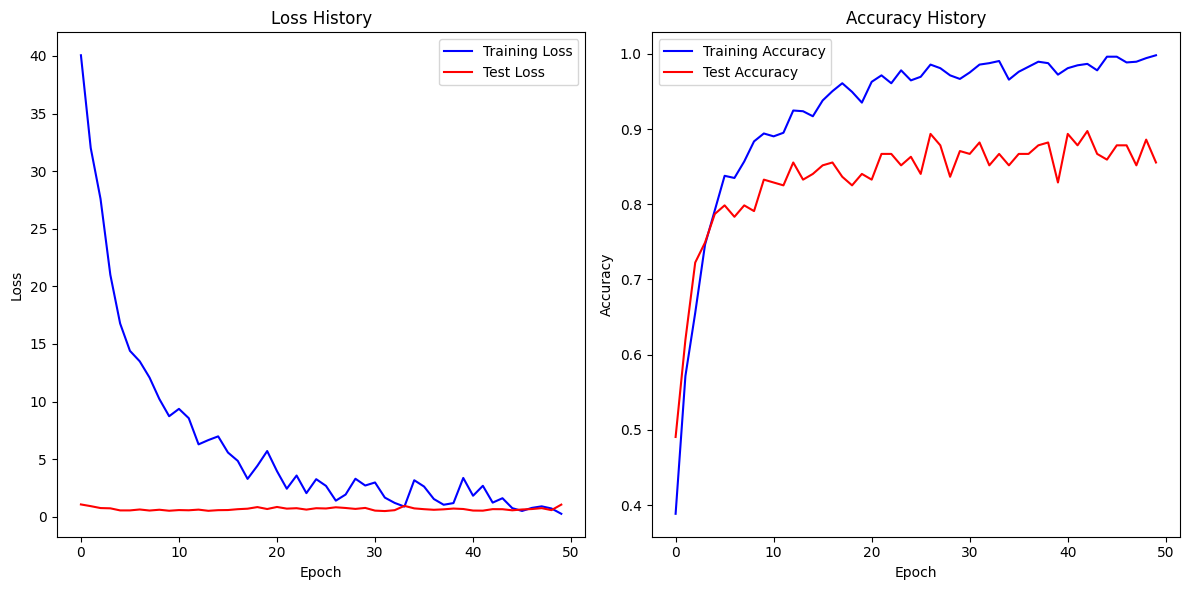

In [51]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 2)

plt.plot(trainAccuracies, label='Training Accuracy', color='blue')

plt.plot(testAccuracies, label='Test Accuracy', color='red') 

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() 
plt.title('Accuracy History')

plt.subplot(1, 2, 1)

plt.plot(trainLosses, label='Training Loss', color='blue') 

plt.plot(testLosses, label='Test Loss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')


plt.tight_layout()
plt.show()

In [52]:
confusionMAtrixList = {}
for i in range(len(LABELS)):

  tp = confusionMatrix[i,i]

  fn = 0
  for j in range(len(LABELS)):
    if i != j:
      fn += confusionMatrix[i,j]

  fp = 0
  for j in range(len(LABELS)):
    if i != j:
      fp += confusionMatrix[j,i]

  tn = 0
  for j in range(len(LABELS)):
    for k in range(len(LABELS)):
      if i != j and i != k:
        tn += confusionMatrix[j,k]

  conf_mat_2x2 = np.array([[tp, fn], [fp, tn]])
  confusionMAtrixList[LABELS[i]] = conf_mat_2x2


/tmp/ipykernel_42/4044546424.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','True', 'False'])
/tmp/ipykernel_42/4044546424.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'True', 'False'])


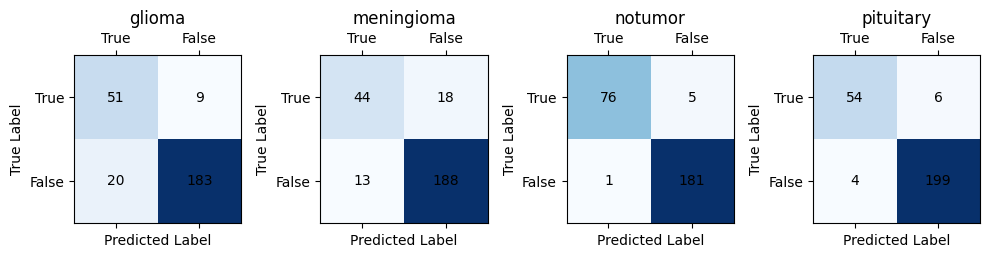

In [53]:
import matplotlib.pyplot as plt

numClasses = len(confusionMAtrixList)
fig, axs = plt.subplots(nrows=1, ncols=numClasses, figsize=(10, 3))

for i, (label, conf_mat) in enumerate(confusionMAtrixList.items()):
    ax = axs[i]

    ax.set_title(label)
    ax.matshow(conf_mat, cmap=plt.cm.Blues)

    for (i, j), z in np.ndenumerate(conf_mat):
        ax.text(j, i, int(z), ha='center', va='center')

    ax.set_yticklabels(['','True', 'False'])
    ax.set_xticklabels(['', 'True', 'False'])
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [69]:

def CalcAccuracy(confMat):
    return confMat[0][0] + confMat[1][1] / np.sum(confMat)

def CalcRecall(confMat):
    fn = confMat[0][1]
    tp = confMat[0][0]
    return tp / (tp + fn)

def CalcPrecision(confMat):
    fp = confMat[1][0] 
    tp = confMat[0][0]
    return tp / (tp + fp)

def CalcF1Score(confMat):
    recall = CalcRecall(confMat)
    precision = CalcPrecision(confMat)
    return 2*(precision*recall) / (precision+recall)

def CalcMetrics(confMat):
    metrics = {}
    metrics["Accuracy"] = CalcAccuracy(confMat) 
    metrics["Precision"] =  CalcPrecision(confMat)
    metrics["Recall"] =  CalcRecall(confMat)
    metrics["F1 Score"] =  CalcF1Score(confMat)
    return metrics

def Macroavg(metricList):
    l = ["Accuracy","Precision","Recall","F1 Score"]
    macroList = {}
    for name in l:
        total = 0
        for label in LABELS:
            total += metricList[label][name]
        macroList[name] = total /4
    return macroList
        
    

def printMetrics(confusionMAtrixList):
    metricList = {}
    for key, value in confusionMAtrixList.items():
        metricList[key] = CalcMetrics(value)
    df = pd.DataFrame(metricList)
    display(df)
    print("Macro Avg",Macroavg(metricList))
    
    

In [70]:
printMetrics(confusionMAtrixList)

,glioma,meningioma,notumor,pituitary
Accuracy,51.695816,44.714828,76.688210,54.756653
Precision,0.718310,0.771930,0.987013,0.931035
Recall,0.850000,0.709677,0.938272,0.900000
F1 Score,0.778626,0.739496,0.962025,0.915254


Macro Avg {'Accuracy': 56.963876724243164, 'Precision': 0.8520717918872833, 'Recall': 0.8494872450828552, 'F1 Score': 0.8488503125477028}
